In [190]:
import numpy as np
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from sklearn.utils import check_random_state
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.validation import column_or_1d
import scipy

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Default Data

In [191]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 1000
noise = 0.25

X = np.abs(2 * rng.randn(num_samples, 1))
Y = np.sin(X) + noise * rng.randn(num_samples, 1)


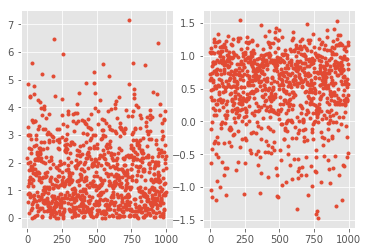

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(X, marker='.', linestyle='')
ax[1].plot(Y, marker='.', linestyle='')
plt.show()

### Univariate Model

* $\alpha$ - Regularization parameter. The number of psuedo-counts to add to each bin of the histogram. It's like putting a dirichlet prior on the empirical bin counds with Dirichlet parameter $\alpha$.
* Bounds - Finite bounds of the histogram. Can be percentage extension or a specified interval [a,b]
* bins - an int or or perhaps we can input specific values for bins.

In [193]:
# Parameters
alpha = 1e-6    # regularization parameter 
bounds = 0.1    # percentage extension
bins = 'auto'  # number of bins or bins estimator parameter

histogram_params = None 

### Check Bounds

**Support**: This is defined as the positive density region.

In [194]:
def check_bounds(X=None, bounds=([-np.inf, np.inf]), extend=True):
    """Checks the bounds. Since we are going from an unbound domain to
    a bounded domain (Random Dist to Uniform Dist) we are going to have
    a problem with defining the boundaries. This function will either 
    have set boundaries or extend the boundaries with with a percentage.
    
    Parameters
    ----------
    X : array-like, default=None
    
    bounds : int or array-like [low, high]
    
    extend : bool, default=True
    
    Returns
    -------
    bounds : array-like
    
    References
    ---------
    https://github.com/davidinouye/destructive-deep-learning/blob/master/ddl/univariate.py#L506
    """
    
    
    default_support = np.array([-np.inf, np.inf])
    
    # Case I - Extension
    if np.isscalar(bounds):
        
        
        if X is None:
            # If no X, return default support (unbounded domain)
            return default_support
        else:
            # extend the domain by x percent
            percent_extension = bounds
            
            # Get the min and max for the current domain
            domain = np.array([np.min(X), np.max(X)])
            
            # Get the mean value of the domain
            center = np.mean(domain)
            
            # Extend the domain on either sides
            domain = (1 + percent_extension) * (domain - center) + center
            
            return domain
    
    
    # Case II - Directly compute
    else:
        domain = column_or_1d(bounds).copy()
        
        if domain.shape[0] != 2:
            raise ValueError('Domain should either be a two element array-like' 
                             ' or a scalar indicating percentage extension of domain.')
        
        return domain

#### Testing - Bounds

In [195]:
# Test Case I - no inputs
bounds = check_bounds()
np.testing.assert_array_equal(bounds, np.array([-np.inf, np.inf]))

# Test Case II - input but no bounds
bounds = check_bounds(X)
np.testing.assert_array_equal(bounds, np.array([-np.inf, np.inf]))

# Test Case III - inputs, bounds
temp_bounds = [0, 1.0]
bounds = check_bounds(X, bounds=temp_bounds)
np.testing.assert_array_equal(bounds, np.array(temp_bounds))

# Test Case VI - no inputs, bounds
temp_bounds = [0, 1.0]
bounds = check_bounds(bounds=temp_bounds)
np.testing.assert_array_equal(bounds, np.array(temp_bounds))

#### Make X inside the Bounds

In [196]:
def make_interior(X, bounds, eps=None):
    """Scale/Shift data to fit in the open interval given by bounds.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix
    
    bounds : array-like, shape (2,)
        Minimum and maximum of bounds.
    
    eps : float, optional
        Epsilon for clipping, defaults to ``np.info(X.dtype).eps``
        
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Data matrix after possible modification
    """
    X = check_floating(X)
    
    if eps is None:
        eps = np.finfo(X.dtype).eps
        
    left = bounds[0] + np.abs(bounds[0] * eps)
    right = bounds[1] - np.abs(bounds[1] * eps)
    return np.minimum(np.maximum(X, left), right)

def check_floating(X):
    if not np.issubdtype(X.dtype, np.floating):
        X = np.array(X, dtype=np.float)
    return X

def make_interior_probability(X, eps=None):
    """Convert data to probability values in the open interval between 0 and 1.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix.
    eps : float, optional
        Epsilon for clipping, defaults to ``np.info(X.dtype).eps``
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Data matrix after possible modification.
    """
    X = check_floating(X)
    if eps is None:
        eps = np.finfo(X.dtype).eps
    return np.minimum(np.maximum(X, eps), 1-eps)

def make_finite(X):
    """Make the data matrix finite by replacing -infty and infty.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix.
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Data matrix as numpy array after checking and possibly replacing
        -infty and infty with min and max of floating values respectively.
    """
    X = check_floating(X)
    return np.minimum(np.maximum(X, np.finfo(X.dtype).min), np.finfo(X.dtype).max)

def make_positive(X):
    """Make the data matrix positive by clipping to +epsilon if not positive.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix.
    Returns
    -------
    X : array, shape (n_samples, n_features)
        Data matrix as numpy array after checking and possibly replacing
        non-positive numbers to +epsilon.
    """
    X = check_floating(X)
    return np.maximum(X, np.finfo(X.dtype).tiny)

#### Testing - Interior X

### Check X

In [197]:
from sklearn.exceptions import DataConversionWarning

def check_X(X, bounds, inverse=False):
    
    bounds = check_bounds(X, bounds)
    
    if np.any(X <= bounds[0]) or np.any(X >= bounds[1]):
        warnings.warn(BoundaryWarning(
            'Input to random variable function has at least one value outside of bounds '
            'but all inputs should be in (bounds[0], bounds[1]) exclusinve. Bounding '
            'values away from bounds[0] and bounds[1].'
        ))
        
        X = make_interior(X, bounds)
    return X

class BoundaryWarning(DataConversionWarning):
    """Warning that data is on the boundary of the required set.
    Warning when data is on the boundary of the domain or range and
    is converted to data that lies inside the boundary. For example, if
    the domain is (0,inf) rather than [0,inf), values of 0 will be made
    a small epsilon above 0.
    """

## Resources

**Plotting Histograms**
* https://realpython.com/python-histograms/


### Histogram Univariate Normal Density

### Fitting

##### Case I - We don't have any specific bins to use

In [198]:
# Parameters
alpha = 1e-6    # regularization parameter 
bounds = 0.01    # percentage extension
bins = 'auto'  # number of bins or bins estimator parameter

histogram_params = None 

# Check X is between the bounds (if not, make the X's inside boundary) 
X = check_X(X, bounds)

# Check bounds
bounds = check_bounds(X, bounds)
print(bins, bounds)
# Fit numpy histogram
hist, bin_edges = np.histogram(X, bins=bins, range=bounds)



auto [-0.03556398  7.17887347]


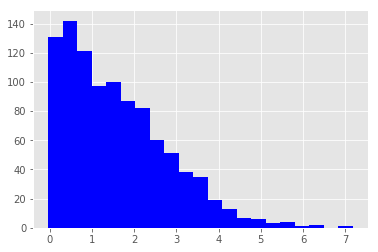

In [199]:
fig, ax = plt.subplots()

plt.hist(X, bins=bins, range=bounds, color='blue')

plt.show()

#### Regularization

In [200]:
fig, ax
# Make into a float for the non-integer value
hist = np.array(hist, dtype=float)
hist += alpha

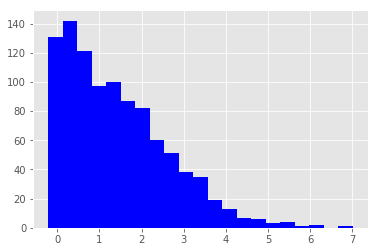

In [201]:
fig, ax = plt.subplots()

plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), color='blue')

plt.show()

## Histogram Uniformization (Manually)

See [scipy.stats.rv_histogram](https://github.com/scipy/scipy/blob/v1.3.0/scipy/stats/_continuous_distns.py#L7265) for inspiration

In [103]:
# Check if X is within Bounds
print(X.min(), X.max())
X_ = check_X(X, bounds)
print(X_.min(), X_.max())

0.00015105322123091746 7.143158436052622
0.00015105322123091746 7.143158436052622


In [105]:
# Check Bounds
print(bounds)

bounds_ = check_bounds(X, bounds)

print(bounds_)

[-0.03556398  7.17887347]
[-0.03556398  7.17887347]


Here we want to extend the domain of the support for the uniform distribution. We have a parameter called `domain_extension` which gives a parameter (in %) for the amount the domain gets shifted.

In [162]:
domain_extension = 0.1

support_extension = (domain_extension / 100) * abs(np.max(X_) - np.min(X_))
print(f"Support Extension: {support_extension}")


old_support = np.array([X_.min(), X_.max()])
new_support = (1 + domain_extension) * (old_support - X_.mean()) + X_.mean()
print(f"Old Support: {old_support}")
print(f"New Support: {new_support}")

Support Extension: 0.007143007382831391
Old Support: [1.51053221e-04 7.14315844e+00]
New Support: [-0.15901853  7.6982896 ]


#### Bin Edges and Bin Centers

In [153]:
def bin_estimation(X, rule='scott'):
    
    n_samples = X.shape[0]
    
    if rule == 'sqrt':
        nbins = np.sqrt(n_samples)
    elif rule == 'scott':
        nbins = (3.49 * np.std(X)) / np.cbrt(n_samples)
    elif rule == 'sturge':
        nbins = 1 + np.log2(n_samples)
    elif rule == 'rice':
        nbins = 2 * np.cbrt(n_samples)
    else:
        raise ValueError(f"Unrecognized rule: {rule}")
        
    
    return int(np.ceil(nbins))

In [186]:
nbins = bin_estimation(X_, rule='sqrt')
print(f"Estimated nbins: {nbins}")


# Get Histogram
hpdf, hbins = np.histogram(X_, bins=nbins)

Estimated nbins: 32


In [188]:
hbin_widths = hbins[1:] - hbins[:-1]

assert(len(hbin_widths) == nbins)

### Scipy Random Variable

In [202]:
import scipy.stats

# Convert Histogram to RV
rv = scipy.stats.rv_histogram((hist, bin_edges))

Now we have access to all of the tools that the scipy library has.

* Sampling
* Score Samples - log-likelihood (log(det(Jacobian))
* CDF
* Inverse CDF
* Get Support
* Entropy

In [203]:
def sample(rv, n_samples=1, random_state=None):
    
    # TODO: check fitted
    
    # control random state
    rng = check_random_state(random_state)
    
    return np.array(rv.rvs(size=n_samples, random_state=rng)).reshape((n_samples, 1))

#### Sampling

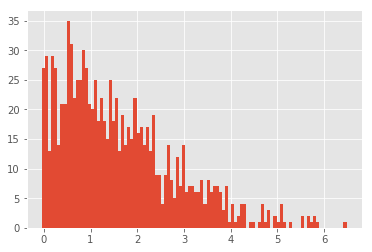

In [205]:
r_sample = sample(rv, n_samples=1000, random_state=123)

fig, ax = plt.subplots()

plt.hist(r_sample, bins=100)

plt.show()

#### CDF Transform - $\mathcal{P}(x) \rightarrow \mathcal U(0, 1)$

In [206]:
def cdf(rv, X, y=None):
    
    # TODO: check X
    return rv.cdf(X.ravel()).reshape((-1, 1))

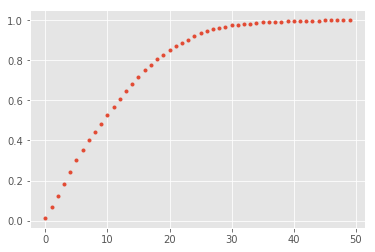

In [207]:
rv_cdf = cdf(rv, np.linspace(X.min(), X.max()))

fig, ax = plt.subplots()

plt.plot(rv_cdf, marker='.', linestyle='')

plt.show()

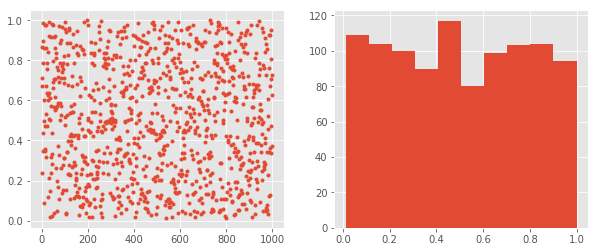

In [208]:
rv_cdf = cdf(rv, X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(rv_cdf, marker='.', linestyle='')
ax[1].hist(rv_cdf)

plt.show()

#### InverseCDF Transform - $\mathcal U(0, 1) \rightarrow \mathcal{P}(x)$

In [209]:
def inverse_cdf(rv, X, y=None):
    
    # TODO: check X
    return rv.ppf(X.ravel()).reshape((-1, 1))

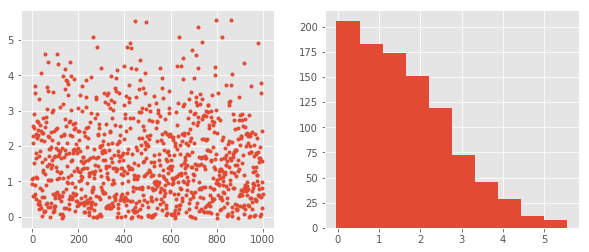

In [210]:
# general samples from uniform dist

u_dist = rng.uniform(0, 1.0, size=(1000, 1))

rv_icdf = inverse_cdf(rv, u_dist)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(rv_icdf, marker='.', linestyle='')
ax[1].hist(rv_icdf)

plt.show()

#### Log Likelihood Under transformation

**TODO**: Check if this is true...

In [211]:
def slogdet(rv, X, y=None):
    """Compute the log-likelihood ( log(det(Jacobian))) for
    each sample. Remember, this is the score under the transformation.
    
    Parameters
    ----------
    
    """
    
    #TODO: check X
    return rv.logpdf(X.ravel()).reshape((-1, 1))

In [212]:
rv_logdet = slogdet(rv, X)

print(rv_logdet.sum())

-1429.7619912061973


#### Entropy

In [213]:
def entropy(rv, X, y=None):
    """Compute the log-likelihood ( log(det(Jacobian))) for
    each sample. Remember, this is the score under the transformation.
    
    Parameters
    ----------
    
    """
    
    #TODO: check X
    return rv.entropy(X.ravel()).reshape((-1, 1))

In [214]:
rv_entropy = entropy(rv, X)

print(rv_entropy.sum())

1429.7620372988208


## Transform

In [37]:
print(rv.a, rv.b)

-0.035563983692926016 7.178873472966779


# TODO: Check that X follows the rules...

https://github.com/davidinouye/destructive-deep-learning/blob/master/ddl/univariate.py#L301

In [38]:
def check_X(self, X, inverse=False):
    
    # Move away from support/domain boundaries if necessary
    if inverse and (np.any(X <= 0) or np.any(X >= 1)):
        X = make_interior_probability(X)
    
    # Make sure data is inside the boundary
    if np.any(X <= 0):
        X = make_interior_probability(X)
    
    # Get Rid of Infs.
    if np.any(np.isinf(X)):
        warnings.warn(BoundaryWarning(
            "Input to random variable function has at least one value is 'np.inf' or "
            "'-np.inf'. Making all input finite via a very large constant."
        ))
    pass

In [39]:
default_support = np.array([-np.inf, np.inf])

# None Default Support Option
percent_extension = 0.1    # comes from bounds parameter


domain = np.array([np.min(X), np.max(X)])
print(domain)


center = np.mean(domain)


domain = (1 + percent_extension) * (domain - center) + center
print(domain.min(), domain.max())


[1.51053221e-04 7.14315844e+00]
-0.3569993159203393 7.500308805194193


## Test Function

In [40]:
import sys
# sys.path.insert(0, '/home/emmanuel/Drives/erc/code/rbig')
sys.path.insert(0, '/Users/eman/Documents/code_projects/rbig')
from rbig.univariate import HistogramUnivariateDensity, InverseCDF

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


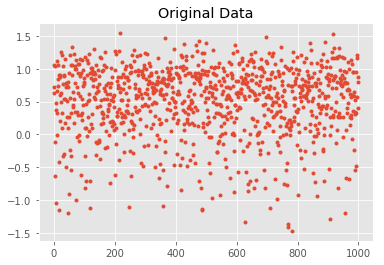

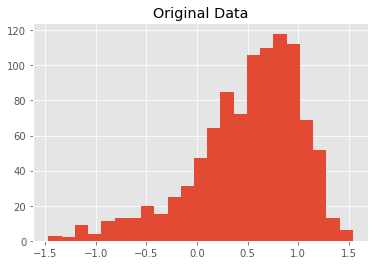

In [41]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 1000
noise = 0.25

X = np.abs(2 * rng.randn(num_samples, 1))
X = np.sin(X) + noise * rng.randn(num_samples, 1)

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(X, marker='.', linestyle='')
ax.set_title('Original Data')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(X, bins='auto')
ax.set_title('Original Data')
plt.show()

In [56]:
# Parameters
alpha = 1e-6    # regularization parameter 
bounds = 0.01    # percentage extension
bins = 'auto'  # number of bins or bins estimator parameter

histogram_params = None 

Bounds: [-1.48361371  1.55530774]
BinEdges: (1.5553077386439662, -1.4836137096616049)
hist: (117, 2)
0.0003415842644207917 0.9994306929685396


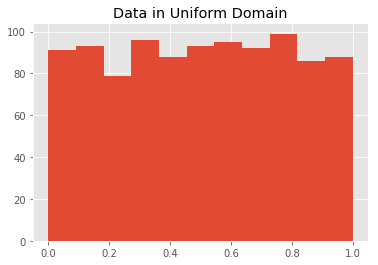

-1.4705116038356147 1.5249544239484412


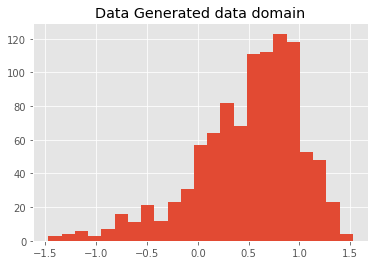

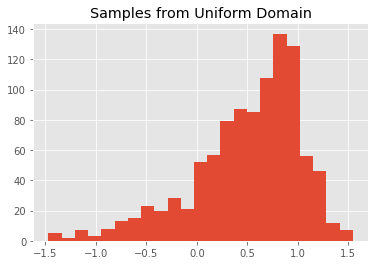

-688.330543524
688.3305670612626


In [57]:
# Initialize Model
uni_model = HistogramUnivariateDensity(alpha=alpha, bounds=bounds, bins=bins)

# Fit Model to Data
uni_model.fit(X)

# Transform Data
X_uni_approx = uni_model.transform(X)
print(X_uni_approx.min(), X_uni_approx.max())
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(X_uni_approx, bins='auto')
ax.set_title('Data in Uniform Domain')
plt.show()

# Inverse Transform Data
X_uni = rng.uniform(0, 1, (1000, 1))
X_approx = uni_model.inverse_transform(X_uni)
print(X_approx.min(), X_approx.max())

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(X_approx, bins='auto')
ax.set_title('Data Generated data domain')
plt.show()

# Generate samples from domain
X_uni_samples = uni_model.sample(n_samples=1000)

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(X_uni_samples, bins='auto')
ax.set_title('Samples from Uniform Domain')
plt.show()

# Calculate Log Jacobian
mll = uni_model.logdetjacobian(X).sum()
print(mll)

# Calculate Entropy
ent = uni_model.entropy(X).sum()
print(ent)

In [68]:
uni_model.get_support(X_uni_samples)

array([[-1.48361371,  1.55530774]])

In [78]:
X_clipped = X_uni_samples[X_uni_samples < 1.5]
print(X_clipped.min(), X_clipped.max())
X_clipped = X_clipped[X_clipped > -1.47]

-1.4706902531563075 1.4658199472645177


In [84]:
X_clipped[:10]

array([-0.54716422,  0.22204777,  0.77382216, -0.35147997,  0.43911272,
        0.43225017,  1.06018281,  0.31913267,  0.7684691 ,  0.05571026])

In [86]:
uni_model.rv.ppf(X_clipped[:10])

array([        nan,  0.1609566 ,  0.91668075,         nan,  0.52167405,
        0.51327841,         nan,  0.32906433,  0.9104216 , -0.55403239])

ValueError: autodetected range of [nan, nan] is not finite

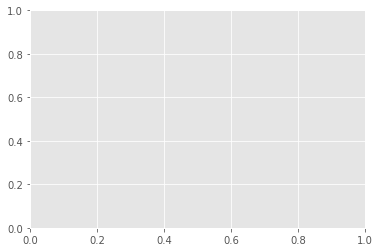

In [81]:
X_gauss = uni_model.rv.ppf(X_clipped[:10])

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.hist(X_gauss, bins='auto')
ax.set_title('Samples from Uniform Domain')
plt.show()

### Testing

1. Generate Some Data - check Log Likelihood and Entropy Measures. Should be the same
2. Test Some Errors? (Data outside bounds...)

In [ ]:
#